O trabalho é reescrever um classificador de nomes seguindo o tutorial no site do pytorch: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html 

Em específico, vocês devem reescrever esse classificador utilizando RNN e LSTM. Utilizem as classes do pytorch. No final, mostrem os resultados comparando essas duas técnicas. 

A entrega será: 

1) Os códigos dos experimentos. Não aceitarei notebook, apenas código fonte .py

2) Um documento detalhando como foram realizados os experimentos. Qual a divisão dos dados entre teste, avaliação e treino? Como os resultados foram avaliados? Quais métricas utilizadas? Quais parâmetros foram utilizados nos modelos? Qual modelo foi melhor? 


In [16]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [17]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [18]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.i2o(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [20]:
input = lineToTensor('Albert')
hidden = lstm.initHidden()

output, next_hidden = lstm(input[0], hidden)
print(output)

tensor([[-2.9470, -2.8893, -2.8373, -2.8450, -2.8955, -2.9388, -2.9654, -2.8948,
         -2.9392, -2.9775, -2.8648, -2.8239, -2.9063, -2.8128, -2.9028, -2.9503,
         -2.8561, -2.8048]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Esparza
category = Polish / line = Bosko
category = Greek / line = Dertilis
category = Vietnamese / line = Phan
category = Polish / line = Wronski
category = French / line = Sargent
category = Spanish / line = Castillion
category = German / line = Krauss
category = Arabic / line = Kattan
category = Russian / line = Beinenson


In [23]:
criterion = torch.nn.NLLLoss()

In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.9905 Quang / Chinese ✗ (Vietnamese)
10000 10% (0m 39s) 2.7224 Basara / Arabic ✓
15000 15% (1m 0s) 2.7195 Tinsley / Greek ✗ (English)
20000 20% (1m 21s) 2.6950 Cheng / Korean ✗ (Chinese)
25000 25% (1m 48s) 2.8842 Pokorny / Dutch ✗ (Polish)
30000 30% (2m 15s) 2.6314 Woodham / Czech ✗ (English)
35000 35% (2m 42s) 2.7289 Martell / French ✗ (Spanish)
40000 40% (3m 4s) 3.3869 Somma / Arabic ✗ (Italian)
45000 45% (3m 27s) 1.9312 Curran / Scottish ✗ (Irish)
50000 50% (3m 50s) 1.3887 Ma / Vietnamese ✗ (Korean)
55000 55% (4m 14s) 2.4081 Meszes / Greek ✗ (Czech)
60000 60% (4m 38s) 2.2048 Peisar / German ✗ (Czech)
65000 65% (5m 2s) 0.6641 Christodoulou / Greek ✓
70000 70% (5m 28s) 0.4745 Kavanagh / Irish ✓
75000 75% (5m 59s) 2.2236 Hanania / Japanese ✗ (Arabic)
80000 80% (6m 30s) 1.6986 Chang / Vietnamese ✗ (Korean)
85000 85% (7m 1s) 2.3942 Baker / German ✗ (English)
90000 90% (7m 26s) 1.5186 De santigo / Portuguese ✗ (Spanish)
95000 95% (7m 53s) 1.4953 Withers / Dutch ✗ (Englis

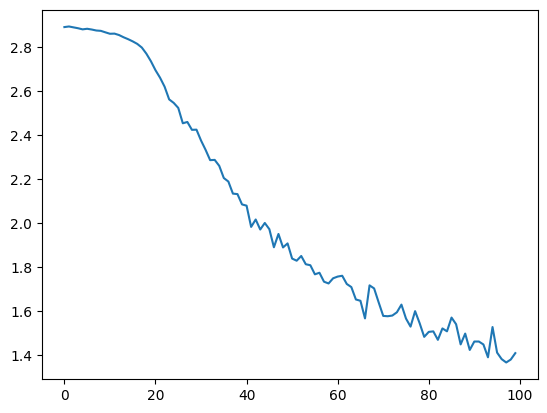

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\arthur.cardoso\AppData\Local\Temp\ipykernel_14568\2048326262.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\arthur.cardoso\AppData\Local\Temp\ipykernel_14568\2048326262.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


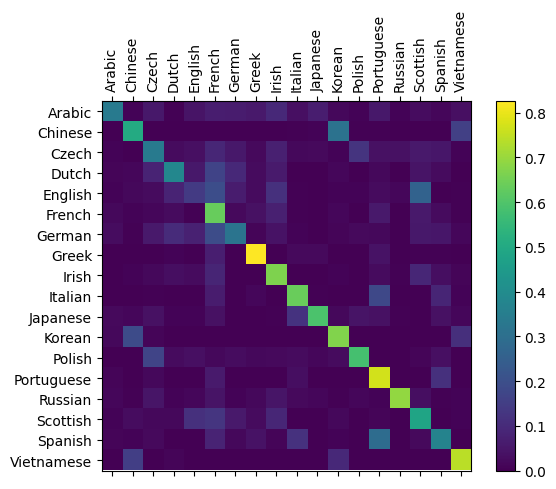

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [37]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Jaegger')
predict('Wang')


> Dovesky
(-0.97) Russian
(-1.53) Czech
(-2.21) English

> Jackson
(-0.47) Scottish
(-1.55) English
(-3.20) Russian

> Jaegger
(-1.35) French
(-1.57) German
(-1.81) Dutch

> Wang
(-0.80) Chinese
(-0.95) Korean
(-2.19) Vietnamese
